# SparkSQL y Spark DataFrames

`SparkSQL` nos permitirá integrar nuestras fuentes manejando JSON y PSV para generar la capa cruda de datos.

Como siempre, empezamos obtniendo el `SparkContext`

In [1]:
import pyspark
sc = pyspark.SparkContext('local[*]')

In [2]:
sqlContext = pyspark.SQLContext(sc)

In [14]:
from pyspark.sql import Row
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
pd.set_option('display.mpl_style', 'default')
get_ipython().magic('matplotlib inline')
plt.rcParams['figure.figsize'] = (15, 5)

## Validamos Tweepy.Stream

Ahora leeremos el archivo de transacciones creado por Tweepy

In [4]:
! wc -l EASentiment.psv EARaw.json

    433 EASentiment.psv
    433 EARaw.json
    866 total


**NOTA**: Aqui validamos que se este generando el archivo con los comentarios de Tweeter.
   - El archivo EASentiment.psv, contiene la calificación del Sentimiento del mensaje, donde los valores pueden ser:
       - muy negativo
       - negativo
       - neutral
       - positivo
       - muy positivo
   - El archivo EARaw.json, contiene los datos completos del mensaje y se consideran todos dado que hay información categorica para tener mayor detalle, donde los campos considerados son:
       - Texto
       - Fecha de creación
       - Zona Horario

## DataFrame desde JSON (Stage 1)

Creamos **Stage #1** generamos la primera generación de datos pasando de JSON a SQLContext

In [5]:
EgyptAirJsons = sqlContext.read.json("EARaw.json")
EgyptAirJsons.registerTempTable("EgyptAirJsons")
pd_tbl_EARaw = sqlContext.sql('select id,text, created_at, user.time_zone from EgyptAirJsons ').toPandas()


In [6]:
pd_tbl_EARaw.head()

,id,text,created_at,time_zone
0,735814134348943360,RT @HuffPostCanada: Canadian killed in EgyptAi...,Thu May 26 12:45:35 +0000 2016,None
1,735814180255600645,@BBCBreaking #IsraelTestsIronDomeAtSea #EgyptA...,Thu May 26 12:45:45 +0000 2016,Central Time (US & Canada)
2,735814203794018306,#aviation #avgeeks #pas13 - https://t.co/LipcZ...,Thu May 26 12:45:51 +0000 2016,None
3,735814248794836992,Airbus : Searchers Detect Emergency Signal of ...,Thu May 26 12:46:02 +0000 2016,Eastern Time (US & Canada)
4,735814285062868993,The Egyptair conspiracy theory sweeping the Ar...,Thu May 26 12:46:10 +0000 2016,Pacific Time (US & Canada)


## RDD desde PSV (Stage 2)

Creamos **Stage #2** generamos la segunda extracción de datos pasando de RDD a SQLContext, esto para lograr la consolidación del resto de la inforamación.

In [7]:
def getTransaccion(linea):
    cells = linea.split('|')
    cells[2] = str(cells[2])
    return Transaccion(*cells)

Creamos **Stage #2** reutilizamos funcion desarrollda en la clase DPA para lectura y formate del schema para RDD.

In [8]:
txs_rdd = sc.textFile("EASentiment.psv")
Transaccion = Row('id', 'sentiment', 'polarity')
txs = txs_rdd.map(getTransaccion)
txs_df = txs.toDF()
txs_df.registerTempTable('EASentiment')
pd_tbl_EASentiment = sqlContext.sql('select id, sentiment, polarity from EASentiment ').toPandas()

In [9]:
pd_tbl_EASentiment.head()

,id,sentiment,polarity
0,735814134348943360,negativo,-0.2
1,735814180255600645,neutral,0.0
2,735814203794018306,neutral,0.0
3,735814248794836992,neutral,0.0
4,735814285062868993,neutral,0.0


## DF y SQLContext (Stage 3)

Se integra la información para tener los datos **consolidados**

In [10]:
pd_jnr_Consolidado = sqlContext.sql('SELECT EASentiment.id, EASentiment.sentiment, EASentiment.polarity, EgyptAirJsons.text, EgyptAirJsons.created_at, EgyptAirJsons.user.time_zone '\
                                    'FROM EASentiment, EgyptAirJsons ' \
                                    'WHERE EASentiment.id = EgyptAirJsons.id')
pd_jnr_Consolidado.registerTempTable('EAConsolidado')
pd_jnr_EAConsolidado = pd_jnr_Consolidado.toPandas()

In [11]:
pd_jnr_EAConsolidado.head()

,id,sentiment,polarity,text,created_at,time_zone
0,735814134348943360,negativo,-0.2,RT @HuffPostCanada: Canadian killed in EgyptAi...,Thu May 26 12:45:35 +0000 2016,None
1,735814180255600645,neutral,0.0,@BBCBreaking #IsraelTestsIronDomeAtSea #EgyptA...,Thu May 26 12:45:45 +0000 2016,Central Time (US & Canada)
2,735814203794018306,neutral,0.0,#aviation #avgeeks #pas13 - https://t.co/LipcZ...,Thu May 26 12:45:51 +0000 2016,None
3,735814248794836992,neutral,0.0,Airbus : Searchers Detect Emergency Signal of ...,Thu May 26 12:46:02 +0000 2016,Eastern Time (US & Canada)
4,735814285062868993,neutral,0.0,The Egyptair conspiracy theory sweeping the Ar...,Thu May 26 12:46:10 +0000 2016,Pacific Time (US & Canada)


# Analisis de Datos con Pandas

## NOTICIAS RELACIONADAS

-Un avión de EgyptAir **se estrella con 66 personas** a bordo.

-Egipto encuentra restos de un cuerpo entre las piezas del avión de EgyptAir

-Egipto difunde fotos de fragmentos del avión siniestrado de Egyptair

-Egipto y Rusia apuntan a que el avión de EgyptAir **sufrió un atentado**

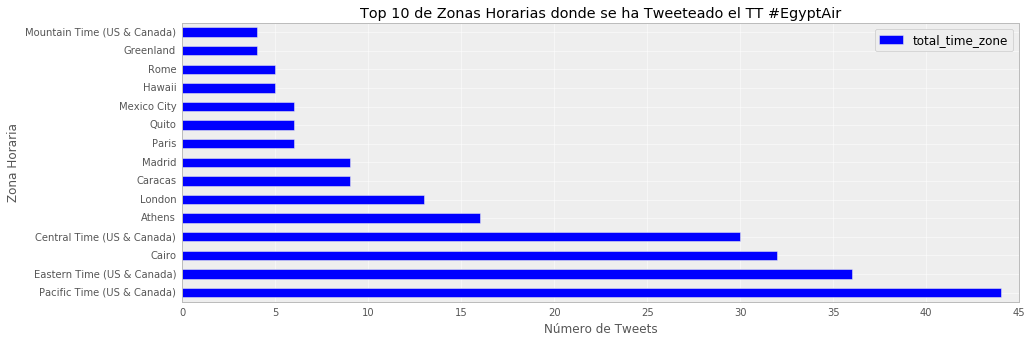

In [15]:
projects_by_country = sqlContext.sql('select time_zone, count(time_zone) as total_time_zone from EAConsolidado group by time_zone order by total_time_zone desc').toPandas()
projects_by_country_pd = projects_by_country.head(15)
projects_by_country_pd=projects_by_country_pd.set_index(['time_zone'])

projects_by_country_pd.plot(kind='barh')
# Etiquetas de la tabla
plt.xlabel('Número de Tweets')
plt.ylabel('Zona Horaria')
plt.title('Top 10 de Zonas Horarias donde se ha Tweeteado el TT #EgyptAir')


- Contar el numero de Tweets por Zona Horaria y poner el Top 10
- Del grafico anterior, se muestran de izquierda a derecha el mayor numero de Tweets acerca del TT EgypAir segun la zona horaria.
- Lo anterior tambien marca un dato curioso que es la **zona de la tendencia**, la cual refleja el interes sobre la nota del avion.


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['monospace'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


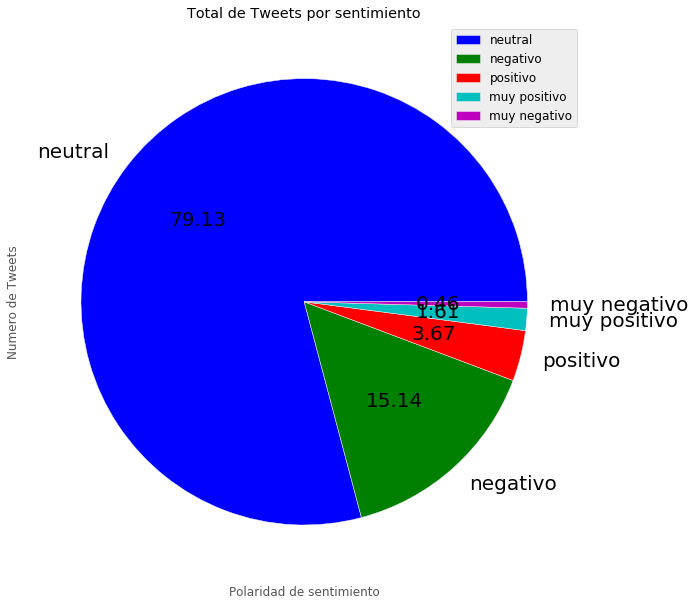

In [32]:
projects_by_sentiment_pd = sqlContext.sql('select sentiment, count(sentiment) as total_sentiment from EAConsolidado group by sentiment order by total_sentiment desc').toPandas()
projects_by_sentiment_pd = projects_by_sentiment_pd.head(20)
projects_by_sentiment_pd=projects_by_sentiment_pd.set_index(['sentiment'])
# Propiedades de Plot
plt.rcParams['figure.figsize'] = (10, 10)
projects_by_sentiment_pd.plot(kind='pie',subplots=True,autopct='%.2f',fontsize=20)
plt.xlabel('Polaridad de sentimiento')
plt.ylabel('Numero de Tweets')
plt.title('Total de Tweets por sentimiento')


- Tweets por categorias de Sentimiento
- Del grafico anterior, se muestran las categorias mas relevante.
- Lo anterior tambien marca un dato curioso que es la ** la tendencia **, la cual refleja el un sentimiento sobre la nota del avion de **Neutral a Negativo**.
